In [1]:
import numpy as np
import torch
import torch.nn as nn
import os

from PIL import Image, ImageOps
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from make_gif_from_folder import make_gif


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(0)
print(device)

width, height = 60, 80
pix_num = width * height


cuda:0


In [2]:
class Net(nn.Module):
    def __init__(self, H):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(H, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H), nn.Sigmoid())
        
    def forward(self, x):
        x.to(device)
        y_pred = self.net(x.flatten())
        
        return y_pred.view(width, height)


In [3]:
def get_grayscale_image_arr(path):
    im = ImageOps.grayscale(Image.open(path))
    image_array = np.array(im).astype(int)
    
    for x in range(im.size[1]):
        for y in range(im.size[0]):
            if image_array[x][y] != 255:
                image_array[x][y] = 0

    image_array = image_array.astype(bool).astype(int)
    return image_array


In [4]:
img_arr = get_grayscale_image_arr('./imgs/1_test.bmp')
bound_length = len(np.where(img_arr == 0)[0])

In [5]:
H, lr = pix_num, 1e-2

model = Net(H)
model.to(device)
model

Net(
  (net): Sequential(
    (0): Linear(in_features=4800, out_features=2400, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=2400, out_features=2400, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=2400, out_features=2400, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=2400, out_features=2400, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=2400, out_features=2400, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=2400, out_features=2400, bias=True)
    (11): ELU(alpha=1.0)
    (12): Linear(in_features=2400, out_features=2400, bias=True)
    (13): ELU(alpha=1.0)
    (14): Linear(in_features=2400, out_features=2400, bias=True)
    (15): ELU(alpha=1.0)
    (16): Linear(in_features=2400, out_features=2400, bias=True)
    (17): ELU(alpha=1.0)
    (18): Linear(in_features=2400, out_features=2400, bias=True)
    (19): ELU(alpha=1.0)
    (20): Linear(in_features=2400, out_features=2400, bias=True)
    (21): ELU(alpha

In [6]:
def loss_fn(y):
    first_integral = 1 -  y[np.where(img_arr > 0)].sum() / (pix_num - bound_length) # хочу НЕ границу единицами    4583 = количество НЕграничных пикселей
    #second_integral = y.abs().sum()
    bound_intgegral = y[np.where(img_arr == 0)].sum() / bound_length # хочу на границе нули
    return bound_intgegral + first_integral

optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [7]:
def train_model(model, num_epochs):
    net_input = torch.tensor([i for i in range(pix_num)]).float().view(width, height).requires_grad_().to(device)
    loss_trace = []
    
    dir_path = 'epoch_outs'
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    for epoch in range(num_epochs):
        optimizer.zero_grad() # обнулил градиенты
        y_pred = model(net_input)# заполнил тензор числами
        
        loss = loss_fn(y_pred) # посчитал лосс
        
        #print(f'Epoch {epoch}, loss: {loss.item()}')
        loss_trace.append(loss.item())
        
        loss.backward() #обновил градиенты
        optimizer.step() #делаю шаг

        # plt.figure(figsize=(20, 10))
        # plt.imshow(y_pred.cpu().detach().numpy(), cmap='gist_gray')
        # plt.title(f'Epoch {epoch + 1}')
        # dir_path = 'epoch_outs'
        # if not os.path.exists(dir_path):
        #     os.mkdir(dir_path)
        # plt.savefig(dir_path + '/epoch%02d.png' % epoch)
        # plt.close()
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            #print(f'Epoch {epoch + 1}')
            
            plt.figure(figsize=(10, 5))
            
            
            plt.subplot(1, 2, 1)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.plot(loss_trace)

            plt.subplot(1, 2, 2)
            plt.imshow(y_pred.cpu().detach().numpy(), cmap='gray')
            plt.title(f'Epoch {epoch + 1}')
            
            plt.savefig(dir_path + '/epoch%04d.png' % (epoch + 1))
            plt.show()
            
    return y_pred

In [8]:
y_pred = train_model(model=model, num_epochs=1300)

KeyboardInterrupt: 

In [9]:
make_gif(dir_path='./epoch_outs')

In [ ]:
y_pred_new = y_pred  * 225.
y_pred_new

tensor([[8.9787e-06, 2.2494e+02, 2.2487e+02,  ..., 2.2500e+02, 2.2500e+02,
         2.2500e+02],
        [2.2497e+02, 3.0577e-03, 2.2500e+02,  ..., 2.2497e+02, 2.2500e+02,
         1.1320e-06],
        [2.2491e+02, 2.2500e+02, 2.2500e+02,  ..., 2.2500e+02, 2.2489e+02,
         2.2500e+02],
        ...,
        [2.2491e+02, 2.2500e+02, 2.2498e+02,  ..., 2.2500e+02, 2.2500e+02,
         2.2500e+02],
        [2.2500e+02, 2.2500e+02, 2.2500e+02,  ..., 2.2498e+02, 2.2500e+02,
         2.2500e+02],
        [2.2492e+02, 2.2493e+02, 2.2500e+02,  ..., 2.2496e+02, 2.2496e+02,
         2.2496e+02]], device='cuda:0', grad_fn=<MulBackward0>)

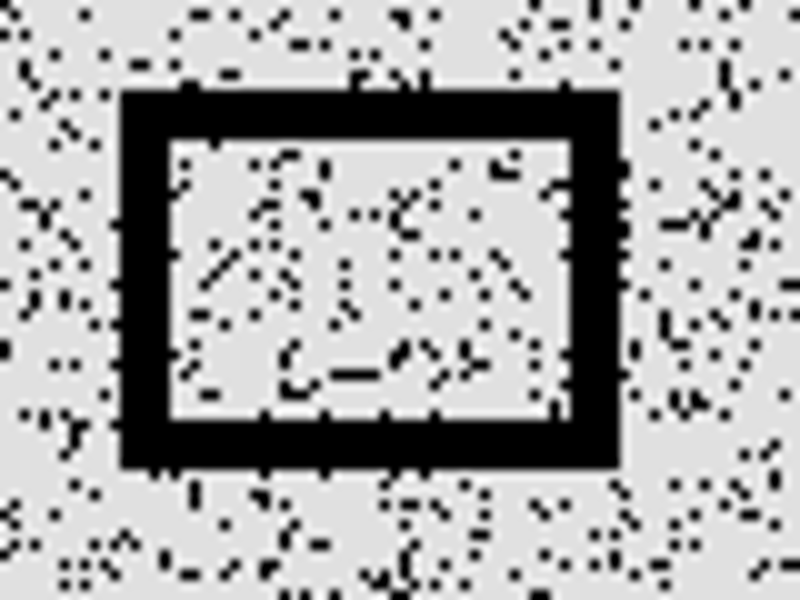

In [ ]:
Image.fromarray(y_pred_new.cpu().detach().numpy().astype('uint8')).resize((800, 600))